In [1]:
import warnings
warnings.filterwarnings("ignore")

___
# Research Strategies that involve CME Weekly, Monday and Wednesday expirations

In [2]:

import zipfile
import glob
import pandas as pd
import numpy as np

from argparse import ArgumentParser
from argparse import RawDescriptionHelpFormatter
import sys
import os
if  not './' in sys.path:
    sys.path.append('./')
if  not '../' in sys.path:
    sys.path.append('../')

from barchartacs import build_db
from barchartacs import db_info
import plotly.graph_objs as go
from plotly.offline import  init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.tools as tls
from plotly.graph_objs.layout import Font,Margin
from IPython import display

import peakutils
from peakutils.plot import plot as pplot
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema


import datetime
import io
from tqdm import tqdm,tqdm_notebook
from barchartacs import pg_pandas as pg
import mibian
import py_vollib
import importlib
from py_vollib import black
from py_vollib.black import implied_volatility
import ipdb
import traceback
import pandas_datareader.data as pdr
from dashapp import dashapp2 as dashapp
import dash_html_components as html
import dash_core_components as dcc
from itertools import accumulate 
import pathlib
import shutil
import urllib.request as request
from contextlib import closing
import zipfile

importlib.reload(dashapp)

<module 'dashapp.dashapp2' from '/Users/bperlman1/Documents/billybyte/pyliverisk/dashapp/dashapp/dashapp2.py'>

In [3]:
from pandas.tseries.holiday import USFederalHolidayCalendar
bday_us = pd.offsets.CustomBusinessDay(calendar=USFederalHolidayCalendar())


2020-06-09 07:35:48,055 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


### important global variables

In [4]:

DEBUG_IT=False
opttab = 'sec_schema.options_table'
futtab = 'sec_schema.underlying_table'


#### get all contracts in the options database

In [5]:
pga = db_info.get_db_info()
print(f"futtab max date: {pga.get_sql(f'select max(settle_date) from {futtab}')}")
print(f"opttab max date: {pga.get_sql(f'select max(settle_date) from {opttab}')}")


  sec_db
futtab max date:         max
0  20200608
opttab max date:         max
0  20200608


In [6]:
def _create_batch_indices(l,n):
    ii = list(range(l))
    num = n
    # list of length in which we have to split 
    length_to_split = list(np.repeat(num,len(ii)/num )) + [len(ii)%num]
    print(length_to_split)

    # Using islice 
    r = [ii[x - y: x] for x, y in zip( 
              accumulate(length_to_split), length_to_split)] 
    return r
_create_batch_indices(11,3)

[3, 3, 3, 2]


[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10]]

In [7]:
def str_to_date(d,sep='-'):
    try:
        dt = datetime.datetime.strptime(str(d)[:10],f'%Y{sep}%m{sep}%d')
    except:
        return None
    return dt

def get_local_peaks_and_valleys(df_in,n,col='close'):
    '''
    :param df - Input DataFrame
    :param n - number of data points that surround peak and valley
    :param col - the data column to observe
    '''
    df = df_in.copy()
    # Find local peaks
    df['valley'] = df.iloc[argrelextrema(df[col].values, np.less_equal, order=n)[0]][col]
    df['peak'] = df.iloc[argrelextrema(df[col].values, np.greater_equal, order=n)[0]][col]
    return df
 
def get_draw_downs(df_in,close='close'):
    df = df_in.copy()
    df['peak'] = df[close].expanding(min_periods=1).max()
    df['drawdown'] = df.peak-df[close]
    return df.drawdown
    

In [8]:
def get_spread(contract_front,contract_back):
    sql = f"""
    with 
    f1 as (
        select *
        from {futtab} 
        where symbol in ('{contract_front}','{contract_back}')
    )
    select * from f1 
    """
    df = pga.get_sql(sql)
    df1 = df[df.symbol==contract_front].copy()
    df2 = df[df.symbol==contract_back].copy()
    df1['front'] = df1.close
    df2['back'] = df2.close
    df_both = df1[['settle_date','front']].merge(
        df2[['settle_date','back']],on='settle_date',how='inner')
    df_both['spread'] = df_both.front - df_both.back
    return df_both

MONTH_CODES = 'FGHJKMNQUVXZ'
DICT_MONTH_CODE = {MONTH_CODES[i]:i+1 for i in range(len(MONTH_CODES))}

def get_CL_expiry(symbol):
    monthcode_yy = symbol[2:]
    month = DICT_MONTH_CODE[monthcode_yy[0]]
    year = 2000 + int(monthcode_yy[1:])
    month = month -1
    if month<1:
        month = 12
        year = year - 1
    return datetime.datetime(year,month,25) - 4*bday_us

def get_NG_expiry(symbol):
    monthcode_yy = symbol[2:]
    month = DICT_MONTH_CODE[monthcode_yy[0]]
    year = 2000 + int(monthcode_yy[1:])
    return datetime.datetime(year,month,1) - 3*bday_us


## Example of showing dashapp.plotly_plot with reverse order descending x axis
The xaxis values must be numbers, and should be consecutive

In [11]:
# syms = ['SIK20','SIZ99']
syms = ['ZCN19','ZCZ19']
sym = ','.join([f"'{v}'" for v in syms])
df_crude = pga.get_sql(f"select symbol,settle_date, close from {futtab} where symbol in ({sym})")
df_crude['settle_dt'] = [dashapp.str_to_date(str(d),sep='') for d in df_crude.settle_date.values]
max_date = df_crude.settle_dt.max()
df_crude['dte'] = (max_date-df_crude.settle_dt).dt.days
df_plot = df_crude[df_crude.symbol==syms[0]].iloc[-100:]
df_plot[syms[0]] = df_plot.close
for s in syms[1:]:
    values = df_crude[df_crude.symbol==s].iloc[-100:].close.values
    if 'Z99' in s:
        values = values/10
    df_plot[s] = values
f1 = dashapp.plotly_plot(
    df_in=df_plot[['dte']+syms],x_column='dte',y_left_label='Closing Price',
    plot_title=f'{sym} Price vs Days To Expiration'
)
f1.update_layout(xaxis={'type':'-','autorange':'reversed','title':'Days To Expiry'})
f2 = dashapp.plotly_plot(
    df_in=df_plot[['settle_date']+syms],x_column='settle_date',y_left_label='Closing Price',
    plot_title=f'{sym} Price vs Settle Date'
)
iplot(f1)
iplot(f2)

In [32]:
for y in range(11,21):
    df_zcn20_zcz20 = get_spread(f'ZCN{y}',f'ZCZ{y}').iloc[-120:]
    iplot(dashapp.plotly_plot(df_in=df_zcn20_zcz20,x_column='settle_date',
                      yaxis2_cols=['spread'],y_right_label='spread',
                              y_left_label='price',
                             plot_title=f'ZCN{y} ZCZ{y}'))

In [34]:
import importlib
importlib.reload(dashapp)
df_c = pga.get_sql(f"select * from {futtab} where symbol='ZCN20'").iloc[-120:]
iplot(dashapp.PlotlyCandles(df_c,date_column='settle_date',title="ZCN20").get_figure())

### Compare rolling "n" day P&L's to at-the-money E2A 5 day put spreads.
1. The emini Monday and Wednesday contracts allow you to trade options with 1 to 7 day expirations on the ES contract.  The put skew of these options allows you to sell ATM call spreads so that you risk less than you make, on a bet that is very close to having a 50% probability of winning.

2. The 10 point up and down call spreads (that expire to a value between 0 and 20) normally trade at about 11.5 when the SP EMini contract underlying is trading in the middle of the upside and downside strikes.  So, if you sell the call spread, you are risking 20 - 11.5 = 9.5 if the market goes to the high strike, and you make 11.5 if the market goes to the low strike. 

3. You will compute the probability of the market going to, or outside of the range of the low/high strikes in 5 days.

4. Compute the rolling "n" day p&l's where the p&l is either the difference between today's close and a previous "n" day close.  However, if that difference is outside of the range +/- ```spread```, then use the value of +/- spread.
5. Example: 
  * The ESM20 is trading at 3100;
  * the 5 day E2AM0 3000/3120 call spread will trade at 11.5;
  * You compute the prob_higher of ESM20 going up to or beyond 3000 or 3020;
  * You sell the call spread for 11.5;
  * If ESM20 >= 3020, you loose 20 - 11.5 = 9.5 * prob_higher;
  * If ESM20 <= 3000, you make 11.5 * (1-prob_higher)


In [194]:
# get all values of ES
df_es99 = pga.get_sql(f"select * from {futtab} where symbol='ESZ99'")

In [341]:
# calculate a rolling "n" day P&L
spread = 10
days = 5
df_es99['nday'] = df_es99.close - df_es99.shift(days).close 
df_es99['nday'] = [(min(abs(v),spread)*v/abs(v)) if v!=0 else 0 for v in df_es99['nday']]
df_es99.nday = df_es99.nday - 1.5 
df_es99['cum_nday'] = df_es99.nday.cumsum() + df_es99.close.values[0]
df_es99['nday_dd'] = get_draw_downs(df_es99,close='cum_nday')
df_es99['close_dd'] = get_draw_downs(df_es99)

In [364]:
# calculate sharpe ratios of buy and hold, and then of going short the put spread
[
    df_es99.close.pct_change().mean()/df_es99.close.pct_change().std()*256**.5,
    df_es99.cum_nday.pct_change().mean()/df_es99.cum_nday.pct_change().std()*256**.5
]


[0.7388154217347606, 1.1667588732973846]

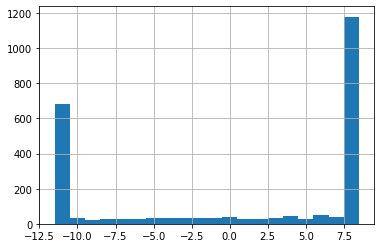

In [366]:
# show a histogram of those p&l's
log = dashapp.logging.getLogger(__name__)
log.setLevel(dashapp.logging.INFO)
display.display(df_es99['nday'].hist(bins=20))
iplot(dashapp.plotly_plot(
    df_in=df_es99[['settle_date','cum_nday','nday_dd','close_dd','close']],
    x_column='settle_date',yaxis2_cols=['nday_dd','close_dd'],y_left_label='cum_nday',
    y_right_label='close',plot_title='Cumulative Short Put Spread P&L vs Buy and Hold'
))

y_defs = [
    ['name','x_column','row','col','is_secondary','yaxis_title'],
    ['close','settle_date',1,1,False,'close'],
    ['cum_nday','settle_date',1,1,True, 'cum_nday'],
    ['close_dd','settle_date',2,1,False,'drawdown'],
    ['nday_dd','settle_date',2,1,False, 'drawdown']
]
df_fig = pd.DataFrame(y_defs[1:],columns=y_defs[0])
subtitles = ['Strategy Values vs Time','Drawdowns vs Time']
df_sub = df_es99[['settle_date','cum_nday','nday_dd','close_dd','close']]
sfig = dashapp.plotly_subplots(df_sub,df_fig,subplot_titles=subtitles)
sfig = go.Figure(sfig)
sfig.update_layout(
    legend=dict(x=0.1, y=1.2,orientation='h'),
    modebar={'orientation': 'v','bgcolor':'grey'}
)


In [349]:
?dashapp.plotly_subplots

In [368]:
# show the count and mean of positive and negative "n" day P&L's
allmean = df_es99['nday'].mean()
allcount = df_es99['nday'].count()
allsum = df_es99['nday'].sum()

upmean = df_es99[df_es99['nday']>0]['nday'].mean()
upcount = df_es99[df_es99['nday']>0]['nday'].count()
upsum = df_es99[df_es99['nday']>0]['nday'].sum()
upprob = upcount/allcount

downmean = df_es99[df_es99['nday']<0]['nday'].mean()
downcount = df_es99[df_es99['nday']<0]['nday'].count()
downsum = df_es99[df_es99['nday']<0]['nday'].sum()

evenmean = evensum = 0
evencount = df_es99[df_es99['nday']==0]['nday'].count()

pd.DataFrame({'direction':['all','up','down','even'],
              'count':[allcount,upcount,downcount,evencount],
              'mean':[allmean,upmean,downmean,evenmean],
              'sum':[allsum,upsum,downsum,evensum],
             'prob':[1,upprob,1-upprob,0]})
# df_es99[df_es99['nday']>0]['nday'].mean(),df_es99[df_es99['nday']<0]['nday'].mean()

,direction,count,mean,sum,prob
0,all,2450,0.678420,1662.13,1.00000
1,up,1448,7.650083,11077.32,0.59102
2,down,1002,-9.396397,-9415.19,0.40898
3,even,0,0.000000,0.00,0.00000


In [372]:
avg_profit = upmean*upprob + downmean * (1-upprob)
total_profit = avg_profit * allcount
avg_profit, total_profit

(0.6784204081632628, 1662.1299999999937)

In [313]:
df_test = df_es99.copy()
# df_test = get_local_peaks_and_valleys(df_test,25)
# df_test2 = df_test[['settle_date','close','peak','valley']]
# df_test2 = df_test2.fillna(method='ffill')
df_test = get_draw_downs(df_test)

df_test2 = df_test[['settle_date','close','drawdown']]
iplot(dashapp.plotly_plot(df_test2,x_column='settle_date',yaxis2_cols=['drawdown']))


Text(0.5, 1.0, 'First estimate')

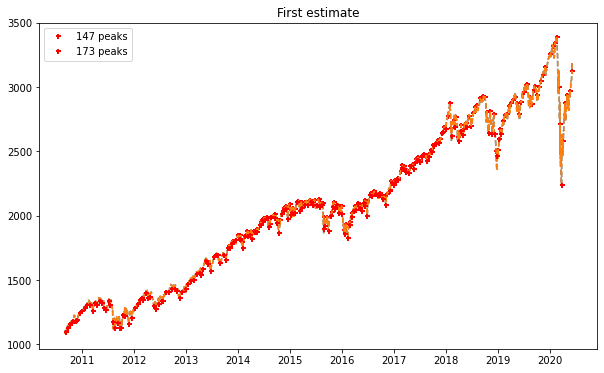

In [373]:
df_test = df_es99.copy()
df_test['date'] = [str_to_date(d,sep='') for d in df_es99.settle_date]
x = df_test.date.values

# get Peaks
y = df_test.high.values
high_indexes = peakutils.indexes(y, thres=0.3, min_dist=7)
# print(high_indexes)
# print(x[high_indexes], y[high_indexes])
plt.figure(figsize=(10,6))

# get Valleys
y = df_test.low.values * -1
low_indexes = peakutils.indexes(y, thres=0.3, min_dist=7)
# print(low_indexes)
y = df_test.close
pplot(x, y, high_indexes)
pplot(x, y, low_indexes)

plt.title('First estimate')
# for sn in dict_df2.keys():
#     df_test = dict_df2[sn]
#     for i in low_indexes:
#         try:
#             f = pu.plotly_candles(df=df_test.iloc[i-3:i+3],number_of_ticks_display=6,title=f'{sn} - {df_test.date.values[i]}')
#         except Exception as e:
#             print(f'{sn} error - {str(e)}')
# print(x[low_indexes])


## END

### Show corn vs crude correlations

In [95]:
sql = f"select settle_date, close  corn from {futtab} where symbol = 'ZCZ99'"
df_corn = pga.get_sql(sql)
sql = f"select settle_date, close  crude from {futtab} where symbol = 'CLZ99'"
df_crude = pga.get_sql(sql)

In [105]:
df_cc = df_crude.merge(df_corn,how='inner',on='settle_date')
df_cc['crude_ret'] = df_cc.crude.pct_change(1)
df_cc['corn_ret'] = df_cc.corn.pct_change(1)

display.display(df_cc.iloc[-50:][['crude','corn']].corr())
display.display(df_cc.iloc[-50:][['crude_ret','corn_ret']].corr())


,crude,corn
crude,1.000000,0.175722
corn,0.175722,1.000000


,crude_ret,corn_ret
crude_ret,1.00000,0.37202
corn_ret,0.37202,1.00000


In [117]:
df_cc['rolling_ret_cor'] = df_cc.crude_ret.rolling(40).corr(df_cc.corn_ret)
iplot(dashapp.plotly_plot(df_in=df_cc[['settle_date','rolling_ret_cor']].iloc[40:],
                         x_column='settle_date',
                          plot_title="Rolling 40 Trading Day Returns Correlation ",
                         y_left_label='Correlation'))

In [128]:
df_cme.columns.values

array(['BizDt', 'Sym', 'ID', 'StrkPx', 'SecTyp', 'MMY', 'MatDt',
       'PutCall', 'Exch', 'Desc', 'LastTrdDt', 'BidPrice', 'OpeningPrice',
       'SettlePrice', 'SettleDelta', 'HighLimit', 'LowLimit',
       'DHighPrice', 'DLowPrice', 'HighBid', 'LowBid', 'PrevDayVol',
       'PrevDayOI', 'FixingPrice', 'UndlyExch', 'UndlyID', 'UndlySecTyp',
       'UndlyMMY', 'BankBusDay'], dtype=object)

In [134]:
len(df_cme)

110313

,BizDt,StrkPx,PutCall,SettlePrice
75075,2020-06-05,3175.0,1.0,23.4
75079,2020-06-05,3185.0,1.0,17.5
75083,2020-06-05,3195.0,1.0,12.7


In [138]:
yyyymmdd = 20200601
fn = f'cme.settle.{yyyymmdd}.s.csv'
cmeurl = f'ftp://ftp.cmegroup.com/settle/{fn}'


In [135]:
df_cme = pd.read_csv(cmeurl)
df_cme.tail()

,BizDt,Sym,ID,StrkPx,SecTyp,MMY,MatDt,PutCall,Exch,Desc,...,HighBid,LowBid,PrevDayVol,PrevDayOI,FixingPrice,UndlyExch,UndlyID,UndlySecTyp,UndlyMMY,BankBusDay
110211,2020-06-01,0BP,0BP,NaN,FUT,202008,2020-08-17,NaN,CME,NaN,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
110212,2020-06-01,0BP,0BP,NaN,FUT,202009,2020-09-14,NaN,CME,NaN,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
110213,2020-06-01,0BP,0BP,NaN,FUT,202010,2020-10-19,NaN,CME,NaN,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
110214,2020-06-01,0BP,0BP,NaN,FUT,202012,2020-12-14,NaN,CME,NaN,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
110215,2020-06-01,0BP,0BP,NaN,FUT,202103,2021-03-15,NaN,CME,NaN,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [374]:
def download_cme_ftp(yyyymmdd,
                     dest_directory = f"{str(pathlib.Path.home())}/downloads",
                    do_ftp=True,fn_base = 'cme.settle'):
    fn = f'{fn_base}.{yyyymmdd}.s.csv'
    cmeurl = f'ftp://ftp.cmegroup.com/settle/{fn}'
    ftpurl = cmeurl+'.zip'
    cmezipfile = fn+'.zip'
    
    dest_zip_path = f"{dest_directory}/{cmezipfile}"
    if do_ftp:
        with closing(request.urlopen(ftpurl)) as r:
            with open(dest_zip_path, 'wb') as f:
                shutil.copyfileobj(r, f)
        with zipfile.ZipFile(dest_zip_path, 'r') as zip_ref:
            zip_ref.extractall(dest_directory)
    dest_csv_file = f"{dest_directory}/{fn}"
#     !ls {dest_zip_path}
    !ls {dest_csv_file}
    return pd.read_csv(dest_csv_file)

In [381]:
def fsd(d):
    '''
    find significant digits
    '''
    for i in range(10):
        d2 = d * 10**i
        d3 = d2 - int(d2)
        if d3 == 0:
            return i
    return -1

def round_to_int(num:float,num_to_round_to:float):
    sign_digits = fsd(num_to_round_to)
    n = num * 10**sign_digits
    int_to_round_to = num_to_round_to * 10**sign_digits
    i = int(round(n/int_to_round_to,0)) * int_to_round_to
    r = i / 10**sign_digits
    return r



In [388]:
[
    round_to_int(3183.2,5),round_to_int(3182.2,5),
    round_to_int(35.82,.5),round_to_int(35.72,.5)
]

[3185, 3180, 36.0, 35.5]

In [380]:
df_nymex = download_cme_ftp(20200605,do_ftp=False,fn_base='nymex.settle')
[v for v in df_nymex.Sym.unique() if 'LO' in v]

/Users/bperlman1/downloads/nymex.settle.20200605.s.csv


['LO', 'LO1', 'LO2', 'LO3', 'LO4']

In [393]:
dict_round={'ES':5,'CL':.5}
# fn_base = 'cme.settle'
# yyyymm = 202006
# do_download = False
# underlying_sym = 'ES'
# sym = 'EA2'
# num_strikes = 2
# cp = 'C'


fn_base = 'nymex.settle'
yyyymm = 202007
do_download = False
underlying_sym = 'CL'
sym = 'LO2'
num_strikes = 1
yyyymmdds = [20200529,20200601,20200602,20200603,20200604,20200605]
cp = 'C'

for d in yyyymmdds:
    cp_num = 1 if cp.lower()=='c' else 0
    df_cme = download_cme_ftp(d,do_ftp=do_download,fn_base=fn_base)
    df_esfut = df_cme[(df_cme.Sym==underlying_sym) & (df_cme.SecTyp=='FUT') & (df_cme.MMY==yyyymm)]
    ss = df_esfut.SettlePrice.values[0]
    rounding = dict_round[underlying_sym]
    cs = round_to_int(ss,rounding)
    
    strk= [cs-rounding*num_strikes,cs,cs+rounding*num_strikes]
    df_cme2 = df_cme[(df_cme.Sym==sym) & (df_cme.StrkPx.isin(strk)) & (df_cme.PutCall==cp_num)]
    df_cme2['futures'] = ss
    display.display(df_cme2[['BizDt','StrkPx','PutCall','SettlePrice','futures']])
    

/Users/bperlman1/downloads/nymex.settle.20200529.s.csv


,BizDt,StrkPx,PutCall,SettlePrice,futures
19115,2020-05-29,35.0,1.0,2.13,35.49
19116,2020-05-29,35.5,1.0,1.84,35.49
19117,2020-05-29,36.0,1.0,1.58,35.49


/Users/bperlman1/downloads/nymex.settle.20200601.s.csv


,BizDt,StrkPx,PutCall,SettlePrice,futures
19207,2020-06-01,35.0,1.0,1.94,35.44
19209,2020-06-01,35.5,1.0,1.67,35.44
19210,2020-06-01,36.0,1.0,1.42,35.44


/Users/bperlman1/downloads/nymex.settle.20200602.s.csv


,BizDt,StrkPx,PutCall,SettlePrice,futures
19264,2020-06-02,36.5,1.0,1.73,36.81
19266,2020-06-02,37.0,1.0,1.47,36.81
19267,2020-06-02,37.5,1.0,1.23,36.81


/Users/bperlman1/downloads/nymex.settle.20200603.s.csv


,BizDt,StrkPx,PutCall,SettlePrice,futures
19279,2020-06-03,37.0,1.0,1.63,37.29
19281,2020-06-03,37.5,1.0,1.37,37.29
19283,2020-06-03,38.0,1.0,1.14,37.29


/Users/bperlman1/downloads/nymex.settle.20200604.s.csv


,BizDt,StrkPx,PutCall,SettlePrice,futures
19294,2020-06-04,37.0,1.0,1.52,37.41
19296,2020-06-04,37.5,1.0,1.24,37.41
19298,2020-06-04,38.0,1.0,0.99,37.41


/Users/bperlman1/downloads/nymex.settle.20200605.s.csv


,BizDt,StrkPx,PutCall,SettlePrice,futures
19341,2020-06-05,39.0,1.0,1.54,39.55
19343,2020-06-05,39.5,1.0,1.27,39.55
19345,2020-06-05,40.0,1.0,1.03,39.55
